<a href="https://colab.research.google.com/github/javierFerreroM/NLP_Project/blob/main/NLP_solucion_separando_sentimientos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se trata de un problema de clasificación multietiqueta en el que tenéis que etiquetar un conjunto de tweets de acuerdo a 11 sentimientos ('anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust').
Disponéis de un conjunto de 3561 tweets etiquetas para entrenar y validar el modelo o modelos necesarios, en el archivo 'sem_eval_train_es.csv'.

Cada alumno tiene que validar sus modelos sobre el conjunto ciego de test con el nombre 'sem_eval_test_blank_es.csv'. Cada Tweet tiene un ID (primera columna) que tenéis que mantener en vuestra solución. Debéis aplicar vuestro modelo entrenado a este conjunto y guardarlo en un archivo CSV de nombre 'soluciones_nombre_apellido1_apellido2.csv'. El archivo CSV a entregar debe tener esta estructura de Pandas:

<class 'pandas.core.frame.DataFrame'>  
RangeIndex: 679 entries, 0 to 678  
Data columns (total 12 columns):  

| #  | Column       |  Non-Null Count  | Dtype |  
|--- | ------       |  --------------  | ----- |  
 0   | ID            | 679 non-null    | object|
 1   | anger         | 679 non-null    | bool  |
 2   | anticipation  | 679 non-null    | bool  |
 3   | disgust       | 679 non-null    | bool  |
 4   | fear          | 679 non-null    | bool  |
 5   | joy           | 679 non-null    | bool  |
 6   | love          | 679 non-null    | bool  |
 7   | optimism      | 679 non-null    | bool  |
 8   | pessimism     | 679 non-null    | bool  |
 9   | sadness       | 679 non-null    | bool  |
 10  | surprise      | 679 non-null    | bool  |
 11  | trust         | 679 non-null    | bool  |
dtypes: bool(11), object(1)
Si el archivo no tiene exactamente esa estructura no se podrá evaluar.

Entrega:

Cada alumno deberá entregar a través de esta tarea habilitada en AV el archivo CSV de las predicciones en el conjunto ciego de test y todo el código en Python utilizado tanto para el entrenamiento de los modelos como la inferencia en el conjunto ciego de test. El código Python se entregará como Notebook de Jupyter.

In [1]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import re
from unidecode import unidecode
from keras.preprocessing.text import Tokenizer
import nltk 
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf

# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_selection import chi2
# from IPython.display import display
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix
# from sklearn import metrics

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/NLP/sem_eval_train_es.csv')
print("Training Set:"% train.columns, train.shape, len(train))
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/NLP/sem_eval_test_blank_es.csv')
print("Test Set:"% test.columns, test.shape, len(test))

Training Set: (3561, 13) 3561
Test Set: (679, 2) 679


Es siempre una buena idea limpiar los datos obtenidos. Debemos eliminar signos de puntuación para evitar introducir ruido en el entrenamiento, dado que símbolos de puntuación tales como @, #, !, etc.

Para ello, la biblioteca de python re nos va a permitir buscar expresiones regulares, para eliminar mayúsculas, etc

In [4]:
train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False


In [5]:
train.info

<bound method DataFrame.info of                  ID                                              Tweet  anger  \
0     2018-Es-01643  @aliciaenp Ajajjaa somos del clan twitteras pe...  False   
1     2018-Es-05142  @AwadaNai la mala suerte del gato fichame la c...  False   
2     2018-Es-05379  @audiomano A mí tampoco me agrado mucho eso. E...   True   
3     2018-Es-00208  Para llevar a los bebes de un lugar a otro deb...  False   
4     2018-Es-01385  @DalasReview me encanta la terrible hipocresia...   True   
...             ...                                                ...    ...   
3556  2018-Es-06340  Ahorita quisiera que mi preocupación más grand...  False   
3557  2018-Es-00439  El mayor criminal del país diciéndole “delincu...   True   
3558  2018-Es-04919  Mi prima de 4 años se ha enfadado conmigo porq...   True   
3559  2018-Es-02703                      @lennycia Jajaja...  Ya seee   False   
3560  2018-Es-02680  Quiero abrazar. Quiero querer. Me hace falta e...  False

In [6]:
# etiquetas = train[['anger', 'anticipation', 'disgust', 'fear', 'joy',
#        'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']]

# filtro = etiquetas.sum(axis=1)<2

# train = train[filtro]

In [7]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower() # pasar todo a minúsculas
    df[text_field] = df[text_field].apply(unidecode) # Eliminar los acentos y símbolos sobre las letras
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  # Eliminar caracteres extraños
    return df
test_clean = clean_text(test, "Tweet")
train_clean = clean_text(train, "Tweet")

In [8]:
train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,ajajjaa somos del clan twitteras perdidas pa ...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,la mala suerte del gato fichame la cara de he...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,a mi tampoco me agrado mucho eso especialment...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,me encanta la terrible hipocresia y doble mor...,True,False,True,False,False,False,False,False,False,False,False


In [9]:
# Check for null values
np.sum(train_clean.isnull().any(axis=1))

0

In [10]:
# Tokenizer: Split sentences into words
# The Embedding layer expects the words to be in numeric form.
nltk.download('punkt')
train_clean['tokenized_sents'] = train_clean.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1)
test_clean['tokenized_sents'] = test_clean.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
train_clean['tokenized_sents']

0       [ajajjaa, somos, del, clan, twitteras, perdida...
1       [la, mala, suerte, del, gato, fichame, la, car...
2       [a, mi, tampoco, me, agrado, mucho, eso, espec...
3       [para, llevar, a, los, bebes, de, un, lugar, a...
4       [me, encanta, la, terrible, hipocresia, y, dob...
                              ...                        
3556    [ahorita, quisiera, que, mi, preocupacion, mas...
3557    [el, mayor, criminal, del, pais, diciendole, d...
3558    [mi, prima, de, 4, anos, se, ha, enfadado, con...
3559                                   [jajaja, ya, seee]
3560    [quiero, abrazar, quiero, querer, me, hace, fa...
Name: tokenized_sents, Length: 3561, dtype: object

{'anger': 1155, 'anticipation': 415, 'disgust': 521, 'fear': 373, 'joy': 1087, 'love': 261, 'optimism': 378, 'pessimism': 578, 'sadness': 845, 'surprise': 169, 'trust': 175, 'tokenized_sents': 0}


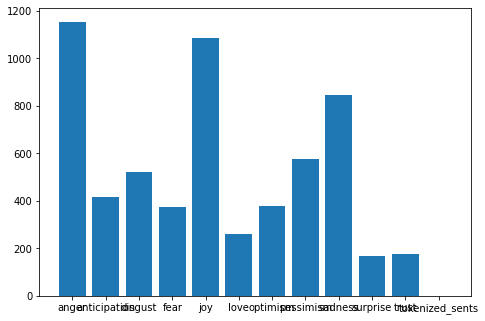

Count of columns in the data is:   14
Count of rows in the data is:   3561


In [12]:
#Check if the classes are imbalanced
count = {}
for i in train_clean.columns:
  if i not in ['ID', 'Tweet']:
    count[i] = len(train_clean[train_clean[i]==True])
print(count)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(count.keys(),count.values())
plt.show()
# Number of rows and columns
print('Count of columns in the data is:  ', len(train_clean.columns))
print('Count of rows in the data is:  ', len(train_clean))

In [13]:
train_clean.head(10)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,tokenized_sents
0,2018-Es-01643,ajajjaa somos del clan twitteras perdidas pa ...,False,False,False,False,True,False,False,False,False,False,False,"[ajajjaa, somos, del, clan, twitteras, perdida..."
1,2018-Es-05142,la mala suerte del gato fichame la cara de he...,False,False,False,True,False,False,False,True,False,False,False,"[la, mala, suerte, del, gato, fichame, la, car..."
2,2018-Es-05379,a mi tampoco me agrado mucho eso especialment...,True,False,False,False,False,False,False,False,False,False,False,"[a, mi, tampoco, me, agrado, mucho, eso, espec..."
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False,"[para, llevar, a, los, bebes, de, un, lugar, a..."
4,2018-Es-01385,me encanta la terrible hipocresia y doble mor...,True,False,True,False,False,False,False,False,False,False,False,"[me, encanta, la, terrible, hipocresia, y, dob..."
5,2018-Es-00089,en venezuela el trafico aereo esta tan peligro...,False,True,False,True,False,False,False,True,False,False,False,"[en, venezuela, el, trafico, aereo, esta, tan,..."
6,2018-Es-05189,me voy a morir sin saber por que y y me die...,False,False,False,True,False,False,False,False,True,False,False,"[me, voy, a, morir, sin, saber, por, que, y, y..."
7,2018-Es-02108,terrible esto,True,False,True,False,False,False,False,False,True,False,False,"[terrible, esto]"
8,2018-Es-00795,para tristeza y felicidad ed sheeran al rescate,False,False,False,False,True,False,False,False,True,False,False,"[para, tristeza, y, felicidad, ed, sheeran, al..."
9,2018-Es-02243,con razon mi vieja se fue rapido a santa fe si...,False,False,False,False,False,False,False,True,False,False,False,"[con, razon, mi, vieja, se, fue, rapido, a, sa..."


In [14]:
# Check the unique words
all_words = []
embedded_sentences = []

for tweet in train_clean['tokenized_sents']:
  for word in tweet:
    all_words.append(word)

unique_words = set(all_words)
print(len(unique_words))

embedded_sentences = [one_hot(tweet, len(unique_words)) for tweet in train_clean['Tweet']]
print(embedded_sentences)

8726
[[6585, 6180, 2967, 816, 7624, 7848, 1086, 4342, 4763], [8692, 2456, 1515, 2967, 1006, 2123, 8692, 7008, 5475, 7519, 7042, 6529], [2326, 1967, 4071, 7042, 4147, 3586, 5788, 8095, 8647, 4091, 5475, 8483, 5267, 7147, 4699], [1533, 7436, 2326, 4160, 6373, 5475, 5154, 2606, 2326, 1216, 5960, 991, 1546, 821, 991, 3407, 3861, 8692, 5245, 7704, 4157], [7042, 7443, 8692, 2026, 464, 2008, 8070, 8130, 4998, 1924, 1898, 764, 505, 7694, 288, 7836, 5671, 375, 5716, 5267, 7167], [7704, 1238, 8483, 3656, 3956, 1898, 1186, 1703, 2648, 8483, 7121, 523, 1678, 6805, 1548], [7042, 939, 2326, 8157, 2476, 5060, 8647, 4998, 2008, 2008, 7042, 3559, 7963, 2008, 4160, 4330, 6534, 3060, 6225, 4998, 3359, 8214], [2026, 103], [1533, 4086, 2008, 7784, 1215, 8049, 78, 6974], [8406, 7640, 1967, 6214, 3359, 654, 7822, 2326, 6987, 5227, 2476, 7762, 5267, 6043, 4998, 7042, 2532, 3257], [5671, 3835, 5475, 5885, 1638, 2326, 2184, 764, 8406, 8692, 4998, 2955, 7414, 5788, 6612, 4287, 6069, 5225, 6090, 5475, 5221, 2326,

In [15]:
# The sentences might have a different length. We want all of them of the same length
word_count = lambda sentence: len(nltk.word_tokenize(sentence))
longest_sentence = max(train_clean['Tweet'], key=word_count)
length_long_sentence = len(nltk.word_tokenize(longest_sentence))
print(length_long_sentence)

33


In [16]:
padded_sentences_train = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences_train)

[[6585 6180 2967 ...    0    0    0]
 [8692 2456 1515 ...    0    0    0]
 [2326 1967 4071 ...    0    0    0]
 ...
 [1967 2741 5475 ...    0    0    0]
 [ 435  523 2046 ...    0    0    0]
 [ 821 3687  821 ...    0    0    0]]


In [17]:
X = padded_sentences_train
Y = train_clean[['anger',	'anticipation',	'disgust',	'fear', 'joy',	'love','optimism', 'pessimism',	'sadness',	'surprise','trust']]

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1, shuffle = False)

In [19]:
X_train

array([[6585, 6180, 2967, ...,    0,    0,    0],
       [8692, 2456, 1515, ...,    0,    0,    0],
       [2326, 1967, 4071, ...,    0,    0,    0],
       ...,
       [8286, 1924, 5154, ...,    0,    0,    0],
       [1922,  408, 5475, ...,    0,    0,    0],
       [5971, 2276, 2689, ...,    0,    0,    0]], dtype=int32)

In [20]:
Y_train

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,False,False,False,False,True,False,False,False,False,False,False
1,False,False,False,True,False,False,False,True,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False
4,True,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2843,False,True,False,False,True,False,False,False,False,False,False
2844,False,True,False,True,True,False,True,False,False,False,False
2845,False,False,False,False,True,False,False,False,False,False,False
2846,True,False,False,True,False,False,False,False,False,False,False


In [21]:
# Y_train = Y_train.values.astype(int)

Las columnas no son excluyentes. Cada tweet puede ser de más de un tipo de sentimiento. Por tanto, no es posible balancear el dataset.

Con los datos ya tratados y listos, podemos empezar el entrenamiento

# Multi-lable Text Classification Model with Multiple Output Layers
ref. https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/

The y variable contains the combined output from 6 labels. However, we want to create individual output layer for each label. We will create 6 variables that store individual labels from the training data and 6 variables that store individual label values for the test data.

In [22]:
maxlen = length_long_sentence

input_1 = Input(shape=(maxlen,))
#embedding_layer = Embedding(len(X_train), length_long_sentence, weights=[X_train], trainable=False)(input_1)
embedding_layer = Embedding(len(X_train), length_long_sentence, input_length=length_long_sentence)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)
dense1 = Dense(64,activation = 'relu')(LSTM_Layer1)
dense1 = Dense(32,activation = 'relu')(LSTM_Layer1)
output1 = Dense(1, activation='sigmoid')(dense1)


In [23]:
def get_models():
    models = dict()
    # y_trains = dict()
    history = dict()

    for sent in Y_train.columns:
        model = Model(inputs=input_1, outputs=output1)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
        models[sent] = model
        # y_trains[sent] = Y_train[[sent]].astype(int).values
        y_trains = Y_train[[sent]].astype(int).values
        print(sent)
        history[sent] = model.fit(X_train, y_trains, epochs=50, verbose=1, validation_split = 0.2)

    return models, history

In [24]:
# maxlen = length_long_sentence

# input_1 = Input(shape=(maxlen,))
# embedding_layer = Embedding(len(X_train), length_long_sentence, weights=[X_train], trainable=False)(input_1)
# embedding_layer = Embedding(len(X_train), length_long_sentence, input_length=length_long_sentence)(input_1)
# LSTM_Layer1 = LSTM(128)(embedding_layer)
# dense1 = Dense(64,activation = 'relu')(LSTM_Layer1)
# output1 = Dense(11, activation='softmax')(dense1)

# model = Model(inputs=input_1, outputs=output1)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [25]:
#y = [y1_train, y2_train, y3_train, y4_train, y5_train, y6_train, y7_train, y8_train, y9_train, y10_train, y11_train]


with tf.device('/GPU:0'):
  models, history =  get_models()
  # for i, column in enumerate(Y_train.columns):
  #   history[i] = model[i].fit((X_train, Y_train[column], epochs=50, verbose=1, validation_split = 0.2))




  # for i in range(11):
  #   history[i] = model[i].fit((X_train, Y_train.columns(i), epochs=50, verbose=1, validation_split = 0.2))

anger
Epoch 1/10
72/72 [==============================] - 8s 26ms/step - loss: 0.6411 - acc: 0.6725 - val_loss: 0.6130 - val_acc: 0.7053
Epoch 2/10
72/72 [==============================] - 1s 13ms/step - loss: 0.6238 - acc: 0.6769 - val_loss: 0.5987 - val_acc: 0.7053
Epoch 3/10
72/72 [==============================] - 1s 13ms/step - loss: 0.5874 - acc: 0.7133 - val_loss: 0.6073 - val_acc: 0.6316
Epoch 4/10
72/72 [==============================] - 1s 13ms/step - loss: 0.4755 - acc: 0.7867 - val_loss: 0.5988 - val_acc: 0.7070
Epoch 5/10
72/72 [==============================] - 1s 15ms/step - loss: 0.4253 - acc: 0.8191 - val_loss: 0.5622 - val_acc: 0.7246
Epoch 6/10
72/72 [==============================] - 1s 14ms/step - loss: 0.3661 - acc: 0.8494 - val_loss: 0.7328 - val_acc: 0.7211
Epoch 7/10
72/72 [==============================] - 1s 13ms/step - loss: 0.3443 - acc: 0.8595 - val_loss: 0.6004 - val_acc: 0.7246
Epoch 8/10
72/72 [==============================] - 1s 15ms/step - loss: 0.34

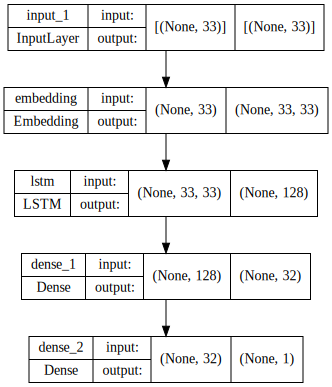

In [26]:
COLAB = True
if COLAB:
    display(SVG(model_to_dot(models['anger'], show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(models['anger'], show_shapes=True).create(prog='dot', format='svg')))

In [27]:
models['anger'].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding (Embedding)       (None, 33, 33)            93984     
                                                                 
 lstm (LSTM)                 (None, 128)               82944     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 181,089
Trainable params: 181,089
Non-trainable params: 0
_________________________________________________________________


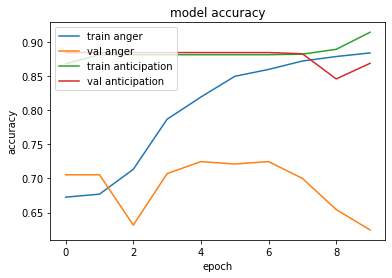

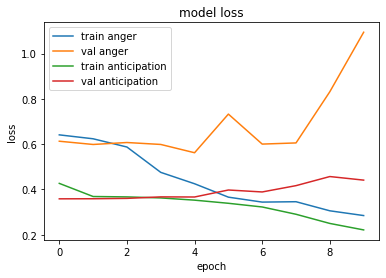

In [28]:
import matplotlib.pyplot as plt

for i in history.keys():
  plt.plot(history[i].history['acc'],label='train %s' % i)
  plt.plot(history[i].history['val_acc'], label='val %s' % i)
  

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
plt.legend(loc='upper left')
plt.show()

for i in history.keys():
  plt.plot(history[i].history['loss'], label='train %s' % i)
  plt.plot(history[i].history['val_loss'],label='val %s' % i)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

In [29]:
def evaluate_models(model):
    score = dict()

    for sent in Y_train.columns:

        # y_trains[sent] = Y_train[[sent]].astype(int).values
        y_tests = Y_test[[sent]].astype(int).values
        score[sent] = model.evaluate(X_test, y_tests, verbose=1)

    return score

In [30]:
for i in models.keys():
  score = evaluate_models(models[i])
  print("Test Score " + str(i) + ":", score[i][0])
  print("Test Accuracy " + str(i) + ":", score[i][1])
  

23/23 [==============================] - 0s 3ms/step - loss: 0.2809 - acc: 0.9144
Test Score anger: 1.3161816596984863
Test Accuracy anger: 0.6409537196159363
23/23 [==============================] - 0s 4ms/step - loss: 0.2809 - acc: 0.9144
Test Score anticipation: 0.4385667145252228
Test Accuracy anticipation: 0.8779803514480591
